# Gradient Boosting Machines Spam Detection Model

In [3]:
import pandas as pd
import numpy as np
import re
import email
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import recmetrics
from sklearn.metrics import confusion_matrix

In [4]:
def get_email_text_from_string(string):
    email_obj = email.message_from_string(string)
    content = []
    for part in email_obj.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
    return ' '.join(content)

def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

## Load and Format Class 0 emails

In [21]:
#Load email data
enron_emails = pd.read_csv('data/emails.csv')

#Format emails
enron_emails["content"] = enron_emails.message.apply(get_email_text_from_string)

enron_emails["content"] = enron_emails.content.apply(func=remove_punctuation)
enron_emails["content"] = enron_emails.content.apply(func=make_lower_case)
enron_emails["content"] =  enron_emails.content.str.replace("\n", " ")
enron_emails["content"] =  enron_emails.content.str.replace("-", "")

#Downsample
enron_emails = enron_emails.sample(5000)
enron_emails.reset_index(drop=True, inplace=True)

# Show example email
print enron_emails.shape
n = np.random.randint(low=0, high=len(enron_emails))
print enron_emails.content[n]

(5000, 3)
ena can confirm the transaction on our omnibus confirmation with one or two minor changes joe please call me also ena sent a draft isda master agreement to puget sound energy on 3 9 99 if you anticipate more financial trading please let me know as we should pursue execution of the isda master agreement thanks sara


## Load and Format Class Spam Emails

In [6]:
#Load frad email data
file_name = open("data/fradulent_emails.txt","rt")
fraud_emails = ''
for line in file_name:
    fraud_emails = fraud_emails + ' ' + line

#format emails and extract body
fraud_emails = fraud_emails.split(" From r  ")
fraud_emails = fraud_emails[1:]

def get_fraud_email_body(string):
    try:
        return string.split(" Status: ",1)[1].decode('ascii')
    except:
        pass
    
fraud_emails = [get_fraud_email_body(string) for string in fraud_emails]
fraud_emails = pd.Series(fraud_emails)
fraud_emails.dropna(inplace=True)

fraud_emails = fraud_emails.apply(func=remove_punctuation)
fraud_emails = fraud_emails.apply(func=make_lower_case)
fraud_emails = fraud_emails.str.replace(r"^o ", "")
fraud_emails = fraud_emails.str.replace(r"^ro ", "")

print fraud_emails.shape
fraud_emails.head()

(3615,)


0    from mr james ngola confidential tel 233 27 58...
1    dear friend i am mr ben suleman a custom offic...
2    from his royal majesty hrm crown ruler of elem...
3    from his royal majesty hrm crown ruler of elem...
4    dear sir it is with a heart full of hope that ...
dtype: object

In [17]:
#Show example email
n = np.random.randint(low=0, high=len(fraud_emails))
fraud_emails[n]

u'hello dear 2e i am writting this letter with due respect and heartful of tears since we have not known or met ourselves previously i am asking for your assistance 2e i want to find out if it s possible for you to deal with individual as to investment 2e i came across your profile and i feel it s highly reputable that is why i pick an interest getting across to you in respect of investment at my disposal 2e i be will so glad if you can allow me and lead me to the right channel towards your assistance to my situation now 2e i will make my proposal well known if i am given the opportunity 2e i would like to use this opportunity to introduce myself to you 2e well i am mr cyril kelvin from liberia 2cthe only son of col 2c kelvin onwun 2c my father is now late 2che died some months back during the last and current crisis in my country 28liberia 29 2e he was one of the high officers in the leadership of formal president charles taylor who is now in exile after many innocent soul were killed

# Create tagged data

In [22]:
all_emails = enron_emails.content.tolist()
all_emails.extend(fraud_emails)
all_emails = pd.DataFrame(all_emails)
all_emails.columns = ["email"]
all_emails["class"] = 0
all_emails.loc[all_emails.index > 5000, "class"] = 1
print all_emails.shape
all_emails.head()

(8615, 2)


,email,class
0,actually i need all of them because i can t te...,0
1,cyril manning po box 15209 boston ma 02215 ctm...,0
2,hi sally thanks for your email attached please...,0
3,jon lindsay park is being a pain in the butt c...,0
4,the friday burrito more fun than a fortune coo...,0


# Test Train Split

In [23]:
emails_train, emails_test, y_train, y_test = train_test_split(all_emails["email"], 
                                                              all_emails["class"], 
                                                              test_size=0.33, 
                                                              random_state=0)
print "{} training observations".format(emails_train.shape[0])
print "{} testing observations".format(emails_test.shape[0])

5772 training observations
2843 testing observations


# Feature Engineering

In [24]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=1000,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=25)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(emails_train)
X_train = svd.fit_transform(tfidf_matrix)

#Transform test data
tfidf_matrix = tf.transform(emails_test)
X_test = svd.transform(tfidf_matrix)

# Gradient Boosting Machines Models

## Sklearn Gradient Boosting Classifier

In [44]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [1000], 'max_depth': [3, 5, 10], 'subsample': [1],
          'learning_rate': [0.01], 'min_samples_leaf': [1]}
gbt = GradientBoostingClassifier(random_state=0)
clf = GridSearchCV(gbt, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1000], 'subsample': [1], 'learning_rate': [0.01], 'max_depth': [3, 5, 10], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 1000,
 'subsample': 1}

In [47]:
#check for overfitting
acc = clf.score(X_train, y_train)
print("Train Accuracy: {:.4f}".format(acc))
acc = clf.score(X_test, y_test)
print("Test Accuracy: {:.4f}".format(acc))

Train Accuracy: 0.9986
Test Accuracy: 0.9870


In [48]:
#Check confusion matrix
pred_test = clf.predict(X_test)
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.99264255, 0.00735745],
       [0.02062706, 0.97937294]])

In [49]:
class_probs = clf.predict_proba(X_test)[:,1]
pred_df = pd.DataFrame([class_probs]).T
pred_df.columns = ["probability"]
pred_df["truth"] = y_test.values
pred_df.head()

,probability,truth
0,0.000735,0
1,0.007039,0
2,0.000759,0
3,0.001096,0
4,0.998662,1


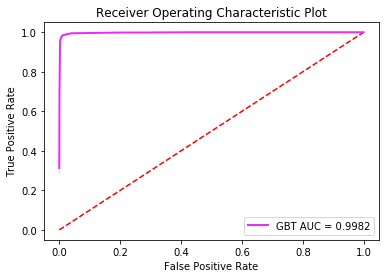

In [50]:
model_probs = [class_probs]
model_names = ["GBT"]
recmetrics.ROCPlot(y_test, model_probs, model_names)

# XGBoost